We are generating sample data for 2D fold bifurcation dynamics under coupled white noise forcing. The differential equation is defined by
\begin{equation*}
    d\begin{pmatrix}X_t\\Y_t\end{pmatrix}=\begin{pmatrix}-X_t^2+\alpha\\-\lambda_Y Y_t\end{pmatrix}d t+\begin{pmatrix}\sigma_X&c\\0&\sigma_Y\end{pmatrix}d\begin{pmatrix}W^X_t\\W^Y_t\end{pmatrix}
\end{equation*}


In [40]:
import sdeint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap
import time
import KM_EWS_methods
import EstimationMethods
plt.rcParams['pgf.texsystem'] = 'pdflatex'
plt.rcParams.update({'font.family': 'serif',
                     'text.usetex': True,
                     'font.serif': ['Helvetica'],
                     'font.size': 2*8,
                     'axes.labelsize': 2*8,
                     'axes.titlesize': 2*12,
                     'figure.titlesize': 2*14})

samplecolor = "black"
theocolor = "red"
samplelinewidth = 2*0.4
theolinewidth = 2*1

Define the parameters of the fold bifurcation

In [2]:
T = 10000 # length of the time series data
oversampling = 100 # 1/oversampling is the time-step of the SDE integration 
tspan = np.linspace(0, T, T * oversampling,endpoint=False)
alpha_0 = 1 # start of bifurcation parameter evolution
alpha_T = -0.1 # end of bifurcation parameter evolution
T_measure = round((alpha_0 - 0.1) / (alpha_0 - alpha_T) * T) # time span for estimations (for linear \alpha evolution)
T_posalpha = round(alpha_0 / (alpha_0 - alpha_T) * T) # time span for theoretical estimator values (for linear \alpha evolution)
xy_0 = np.array([alpha_0**(0.5), 0]) # initial value of the SDE integration
x_off = -2 # x state after bifurcation
lambda_y = 1 # restoring rate of the y dimension
sigma_x = 0.1 # noise strength of x dimension
sigma_y = 2 # noise strength of y dimension
c = 1 # coupling strength of y noise to x dimension
epsilon = 0.1 # general noise amplitude to ensure late noise-induced tipping
permanent_epsilon = epsilon
# bifurcation parameter evolution (should be linear)
def alpha(t):
    return alpha_0 * (1 - t/T) + alpha_T * t/T

# deterministic evolution, fold bifurcation normal form
def f(xy,t):
    if xy[0]>x_off / 2:
        return np.array([-xy[0]**2 + alpha(t),-lambda_y * xy[1]])
    else:
        return np.array([-(xy[0] - x_off), -lambda_y*xy[1]])

# function for the case where both dimensions weaken
#def f(xy,t):
#    if xy[0]>x_off / 2:
#        return np.array([-xy[0]**2 + alpha(t),-lambda_x(alpha(t)) * xy[1]])
#    else:
#        return np.array([-(xy[0] - x_off), -lambda_y*xy[1]])

# noise strength matrix
def G(xy,t):
    return epsilon * np.array([[sigma_x, c],[0, sigma_y]])

# linearised restoring force in x dimension, specifically for fold bifurcation
def lambda_x(alpha):
    if alpha>0:
        return 2 * np.sqrt(alpha)
    else:
        return 1

Integrate a collection of sample paths

In [3]:
samplesize = 20 # number of sample paths to perform estimations on
samplepaths = []
for i in range(samplesize):
    samplepaths.append(np.transpose(sdeint.itoint(f,G,xy_0,tspan)[::oversampling]))

Calculate the observable 
\begin{equation*}
    \Psi_t:=\cos(\beta)X_t+\sin(\beta)Y_t.
\end{equation*}

In [3]:
beta = -np.pi/4 # angle of x, y signal mixing
samplepsis = [np.cos(beta)*samplepaths[i][0]+np.sin(beta)*samplepaths[i][1] for i in range(samplesize)]

NameError: name 'samplesize' is not defined

Define the centering/detrending function and the estimators for the variance and lag-1 autocorrelation of a window

In [4]:
def quadratic_detrending(data_array):
    fit = np.polyfit(range(len(data_array)), data_array, 2)
    return data_array - [x**2 * fit[0] + x * fit[1] + fit[2] for x in range(len(data_array))]

def variance_estimator(data_array):
    data_array = quadratic_detrending(data_array)
    return sum([x**2 for x in data_array])/len(data_array)

def ac1_estimator(data_array):
    data_array = quadratic_detrending(data_array)
    return sum([data_array[i]*data_array[i + 1] for i in range(len(data_array)-1)])/(len(data_array)-1)/variance_estimator(data_array)

def power_spectrum(data_array):
    data_array = quadratic_detrending(data_array)
    fouriertransform = np.fft.rfft(data_array)[1:round(len(data_array) / 2)]
    return abs(fouriertransform) ** 2 / len(data_array)

def Smax_estimator(data_array):
    S = power_spectrum(data_array)
    return np.max(S)

def KM_lambda_estimator(data_array):
    data_array = quadratic_detrending(data_array)
    return KM_EWS_methods.lambda_estimator(data_array)

def phi_estimator(data_array):
    data_array = quadratic_detrending(data_array)
    return EstimationMethods.phi_gls(data_array)

def PSD_lambda_estimator(data_array):
    data_array = quadratic_detrending(data_array)
    return EstimationMethods.lambda_psd(data_array, initial=[1,1,1])


Calculate the running-window estimations of the variance and lag-1 autocorrelation for each of the sample paths. Then calculate the mean value of the estimators in each window.

In [6]:
windowsize = 1000 # window size for each estimation
leap = 100 # gap between successive estimations on the time-series data
samplevars = []
sampleac1s = []
sampleSmaxs = []
sampleKM_lambdas = []
samplephis = []
samplePSD_lambdas = []
for i in range(samplesize):
    samplevars.append([])
    sampleac1s.append([])
    sampleSmaxs.append([])
    sampleKM_lambdas.append([])
    samplephis.append([])
    samplePSD_lambdas.append([])
    for j in range(0,T_measure-windowsize,leap):
        samplevars[i].append(variance_estimator(samplepsis[i][j: j + windowsize]))
        sampleac1s[i].append(ac1_estimator(samplepsis[i][j: j + windowsize]))
        sampleSmaxs[i].append(Smax_estimator(samplepsis[i][j: j + windowsize]))
        sampleKM_lambdas[i].append(KM_lambda_estimator(samplepsis[i][j: j + windowsize]))
        samplephis[i].append(phi_estimator(samplepsis[i][j: j + windowsize]))
        samplePSD_lambdas[i].append(PSD_lambda_estimator(samplepsis[i][j: j + windowsize]))
samplevars = np.array(samplevars)
sampleac1s = np.array(sampleac1s)
sampleSmaxs = np.array(sampleSmaxs)
sampleKM_lambdas = np.array(sampleKM_lambdas)
samplephis = np.array(samplephis)
samplePSD_lambdas = np.array(samplePSD_lambdas)
meansamplevar = np.mean(samplevars, axis = 0)
meansampleac1 = np.mean(sampleac1s, axis = 0)
meansampleSmax = np.mean(sampleSmaxs, axis = 0)
meansampleKM_lambda= np.mean(sampleKM_lambdas, axis = 0)
meansamplephi = np.mean(samplephis, axis = 0)
meansamplePSD_lambda = np.mean(samplePSD_lambdas, axis = 0)

Define the theoretical functions for the variance and lag-1 autocorrelation of the observable as functions of the linear restoring rate $\lambda_x$. Also define the theoretical fixed points as a function of the parameter $\alpha$.

In [5]:
def theovar(lambda_x, beta=beta):
    return epsilon**2 * (np.cos(beta)**2 * (sigma_x**2 + c**2) / (2 * lambda_x)
                         + 2 * np.cos(beta) * np.sin(beta) * sigma_y * c / (lambda_x + lambda_y)
                         + np.sin(beta)**2 * sigma_y**2 / (2 * lambda_y))

def theoac1(lambda_x, beta=beta):
    return epsilon**2 * (np.exp(-lambda_x) * np.cos(beta)**2 * (sigma_x**2 + c**2) / (2 * lambda_x)
                         + (np.exp(-lambda_x) + np.exp(-lambda_y)) * np.cos(beta) * np.sin(beta) * sigma_y * c / (lambda_x + lambda_y)
                         + np.exp(-lambda_y) * np.sin(beta)**2 * sigma_y**2 / (2 * lambda_y)) / theovar(lambda_x, beta)

def theoxfix(alpha):
    if alpha >= 0:
        return np.sqrt(alpha)
    else:
        return x_off

def theoyfix(alpha):
    return 0

def theopsifix(alpha):
    return np.cos(beta) * theoxfix(alpha) + np.sin(beta) * theoyfix(alpha)



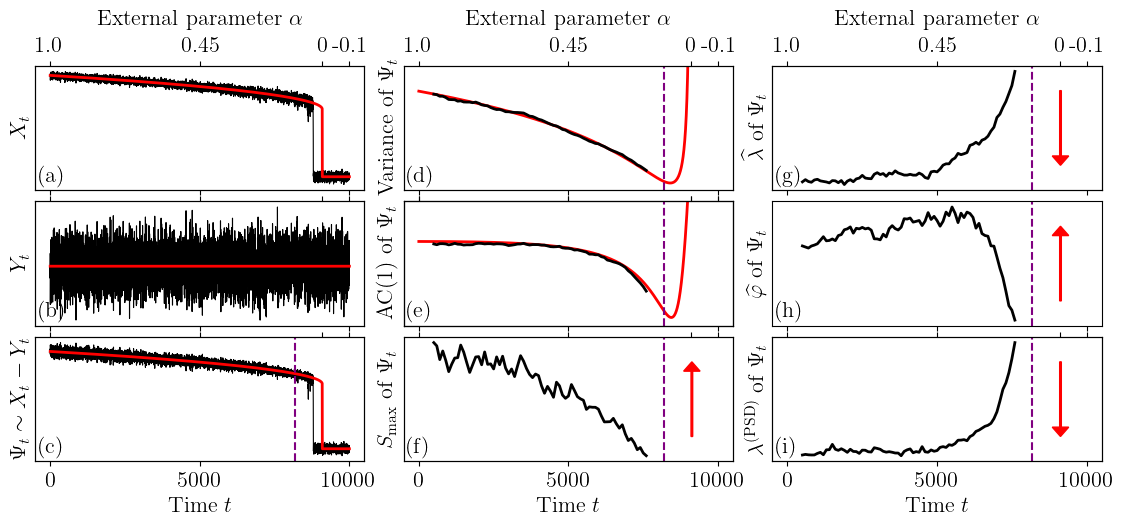

In [8]:
fig, axs = plt.subplots(nrows=3, ncols=3,figsize=(2*6.2, 4.6), sharex=True)
[xplt, varplt, KMplt, yplt, ac1plt, phiplt, psiplt, Splt, PSDplt] = axs.flatten()

props = dict(edgecolor="none", facecolor='white', alpha=0)
xplt.plot(samplepaths[0][0], color = samplecolor, linewidth = samplelinewidth)
xplt.plot([theoxfix(alpha(t)) for t in range(0, T)], color = theocolor, linewidth = theolinewidth)
xplt.set_ylabel("$X_t$")
xplt.text(0.01, 0.2, "(a)", transform=xplt.transAxes, verticalalignment='top', bbox=props)
alphaxplt = xplt.twiny()
alphaxplt.set_xlim(xplt.get_xlim())
ticklist = np.sort(np.append(alphaxplt.get_xticks(), T_posalpha))
alphaxplt.set_xticks(ticklist)
alphaxplt.set_xlim(xplt.get_xlim())
ticklabellist = [round(alpha(t),2) for t in [t for t in ticklist if t<T_posalpha]] + [0] + [round(alpha(t),2) for t in [t for t in ticklist if t>T_posalpha]]
alphaxplt.set_xticklabels(ticklabellist)
alphaxplt.set_xlabel(r"External parameter $\alpha$", labelpad=8)
yplt.plot(samplepaths[0][1], color = samplecolor, linewidth = samplelinewidth)
yplt.plot([theoyfix(alpha(t)) for t in range(0, T)], color = theocolor, linewidth = theolinewidth)
yplt.set_ylabel("$Y_t$")
yplt.text(0.01, 0.2, "(b)", transform=yplt.transAxes, verticalalignment='top', bbox=props)
alphayplt = yplt.twiny()
alphayplt.set_xticks(alphaxplt.get_xticks())
alphayplt.set_xlim(alphaxplt.get_xlim())
alphayplt.set_xticklabels([])
psiplt.plot(samplepsis[0], color = samplecolor, linewidth = samplelinewidth)
psiplt.plot([theopsifix(alpha(t)) for t in range(0, T)], color = theocolor, linewidth = theolinewidth)
psiplt.axvline(T_measure, linestyle = "dashed", color = "purple")
psiplt.set_ylabel("$\Psi_t\sim X_t-Y_t$")
psiplt.text(0.01, 0.2, "(c)", transform=psiplt.transAxes, verticalalignment='top', bbox=props)
psiplt.set_xlabel("Time $t$")
alphapsiplt = psiplt.twiny()
alphapsiplt.set_xticks(alphaxplt.get_xticks())
alphapsiplt.set_xlim(alphaxplt.get_xlim())
alphapsiplt.set_xlim(xplt.get_xlim())
alphapsiplt.set_xticklabels([])
varplt.plot([theovar(lambda_x(alpha(t))) for t in range(0, T_posalpha)], color = theocolor, linewidth = theolinewidth)
varplt.plot(range(round(windowsize / 2), T_measure - round(windowsize / 2), leap), meansamplevar, color = samplecolor, linewidth = theolinewidth)
varplt.axvline(T_measure, linestyle = "dashed", color = "purple")
varplt.set_ylabel("Variance of $\Psi_t$")
varplt.set_ylim([0.7 * min(meansamplevar), 1.2 * max(meansamplevar)])
varplt.text(0.01, 0.2, "(d)", transform=varplt.transAxes, verticalalignment='top', bbox=props)
alphavarplt = varplt.twiny()
alphavarplt.set_xlim(xplt.get_xlim())
ticklist = np.sort(np.append(alphavarplt.get_xticks(), T_posalpha))
alphavarplt.set_xticks(ticklist)
alphavarplt.set_xlim(xplt.get_xlim())
ticklabellist = [round(alpha(t),2) for t in [t for t in ticklist if t<T_posalpha]] + [0] + [round(alpha(t),2) for t in [t for t in ticklist if t>T_posalpha]]
alphavarplt.set_xticklabels(ticklabellist)
alphavarplt.set_xlabel(r"External parameter $\alpha$", labelpad=8)
ac1plt.plot([theoac1(lambda_x(alpha(t))) for t in range(0, T_posalpha)], color = theocolor, linewidth = theolinewidth)
ac1plt.plot(range(round(windowsize / 2), T_measure - round(windowsize / 2), leap), meansampleac1, color = samplecolor, linewidth = theolinewidth)
ac1plt.axvline(T_measure, linestyle = "dashed", color = "purple")
ac1plt.set_ylabel("AC(1) of $\Psi_t$")
ac1plt.set_ylim([0.1, 0.65])
ac1plt.text(0.01, 0.2, "(e)", transform=ac1plt.transAxes, verticalalignment='top', bbox=props)
alphaac1plt = ac1plt.twiny()
alphaac1plt.set_xticks(alphaxplt.get_xticks())
alphaac1plt.set_xlim(alphaxplt.get_xlim())
alphaac1plt.set_xlim(xplt.get_xlim())
alphaac1plt.set_xticklabels([])
Splt.plot(range(round(windowsize / 2), T_measure - round(windowsize / 2), leap), meansampleSmax, color = samplecolor, linewidth = theolinewidth)
Splt.axvline(T_measure, linestyle = "dashed", color = "purple")
Splt.set_ylabel(r"$S_\mathrm{max}$ of $\Psi_t$")
Splt.text(0.01, 0.2, "(f)", transform=Splt.transAxes, verticalalignment='top', bbox=props)
Splt.arrow(0.875, 0.2, 0, 0.6, width = 0.005, head_width=0.05, length_includes_head = True, transform=Splt.transAxes, color="red")
alphaSplt = Splt.twiny()
alphaSplt.set_xticks(alphaxplt.get_xticks())
alphaSplt.set_xlim(alphaxplt.get_xlim())
alphaSplt.set_xlim(xplt.get_xlim())
alphaSplt.set_xticklabels([])
Splt.set_xlabel("Time $t$")
KMplt.plot(range(round(windowsize / 2), T_measure - round(windowsize / 2), leap), meansampleKM_lambda, color = samplecolor, linewidth = theolinewidth)
KMplt.axvline(T_measure, linestyle = "dashed", color = "purple")
KMplt.set_ylabel(r"$\widehat\lambda$ of $\Psi_t$")
KMplt.text(0.01, 0.2, "(g)", transform=KMplt.transAxes, verticalalignment='top', bbox=props)
KMplt.arrow(0.875, 0.8, 0, -0.6, width = 0.005, head_width=0.05, length_includes_head = True, transform=KMplt.transAxes, color="red")
alphaKMplt = KMplt.twiny()
alphaKMplt.set_xlim(xplt.get_xlim())
ticklist = np.sort(np.append(alphaKMplt.get_xticks(), T_posalpha))
alphaKMplt.set_xticks(ticklist)
alphaKMplt.set_xlim(xplt.get_xlim())
ticklabellist = [round(alpha(t),2) for t in [t for t in ticklist if t<T_posalpha]] + [0] + [round(alpha(t),2) for t in [t for t in ticklist if t>T_posalpha]]
alphaKMplt.set_xticklabels(ticklabellist)
alphaKMplt.set_xlabel(r"External parameter $\alpha$", labelpad=8)
phiplt.plot(range(round(windowsize / 2), T_measure - round(windowsize / 2), leap), meansamplephi, color = samplecolor, linewidth = theolinewidth)
phiplt.axvline(T_measure, linestyle = "dashed", color = "purple")
phiplt.set_ylabel(r"$\widehat\varphi$ of $\Psi_t$")
#phiplt.set_ylim([0.1, 0.65])
phiplt.text(0.01, 0.2, "(h)", transform=phiplt.transAxes, verticalalignment='top', bbox=props)
phiplt.arrow(0.875, 0.2, 0, 0.6, width = 0.005, head_width=0.05, length_includes_head = True, transform=phiplt.transAxes, color="red")
alphaphiplt = ac1plt.twiny()
alphaphiplt.set_xticks(alphaxplt.get_xticks())
alphaphiplt.set_xlim(alphaxplt.get_xlim())
alphaphiplt.set_xlim(xplt.get_xlim())
alphaphiplt.set_xticklabels([])
PSDplt.plot(range(round(windowsize / 2), T_measure - round(windowsize / 2), leap), meansamplePSD_lambda, color = samplecolor, linewidth = theolinewidth)
PSDplt.axvline(T_measure, linestyle = "dashed", color = "purple")
PSDplt.set_ylabel(r"$\lambda^\mathrm{(PSD)}$ of $\Psi_t$")
PSDplt.text(0.01, 0.2, "(i)", transform=PSDplt.transAxes, verticalalignment='top', bbox=props)
PSDplt.arrow(0.875, 0.8, 0, -0.6, width = 0.005, head_width=0.05, length_includes_head = True, transform=PSDplt.transAxes, color="red")
alphaPSDplt = PSDplt.twiny()
alphaPSDplt.set_xticks(alphaxplt.get_xticks())
alphaPSDplt.set_xlim(alphaxplt.get_xlim())
alphaPSDplt.set_xlim(xplt.get_xlim())
alphaPSDplt.set_xticklabels([])
PSDplt.set_xlabel("Time $t$")

[plots.set_yticks([]) for plots in [xplt, varplt, KMplt, yplt, ac1plt, phiplt, psiplt, Splt, PSDplt]]
#[plots.yaxis.set_label_coords(-0.12,.5) for plots in [xplt, yplt, psiplt]]
#[plots.yaxis.set_label_coords(1.18,.5) for plots in [varplt, ac1plt, Splt]]
fig.subplots_adjust(left=.13, bottom=.07, right=.99, top=.93, hspace=.09, wspace=.12)
#plt.savefig("Plots/FoldObservable" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True, bbox_inches="tight")
plt.show()

Plot theoretical values as functions of $\lambda_X$

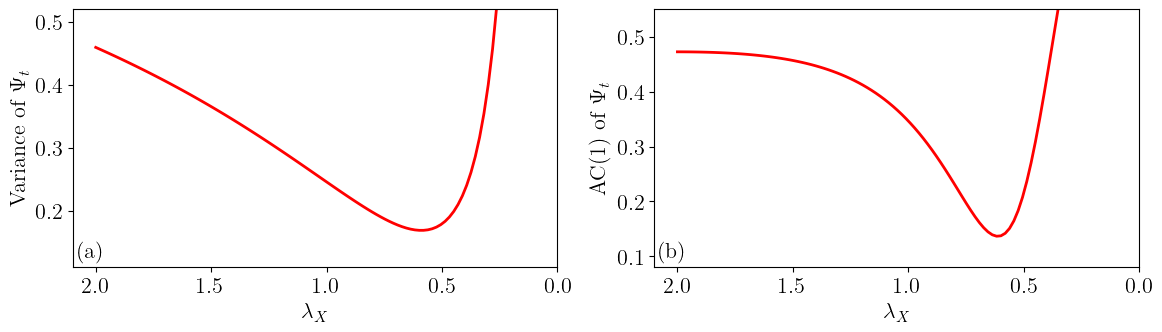

In [106]:
epsilon = 1
fig, [varplt, ac1plt] = plt.subplots(nrows=1, ncols=2, figsize=(2*6.2, 3))
props = dict(edgecolor="none", facecolor='white', alpha=0)
varplt.plot(np.linspace(2, 0.15, 100), [theovar(lambda_x) for lambda_x in np.linspace(2, 0.1, 100)], color = theocolor, linewidth = theolinewidth)
varplt.set_ylabel("Variance of $\Psi_t$")
varplt.text(0.01, 0.1, "(a)", transform=varplt.transAxes, verticalalignment='top', bbox=props)
varplt.set_xlabel("$\lambda_X$")
varplt.set_xlim([0,2.1])
varplt.set_ylim([0.11,0.52])
varplt.invert_xaxis()
ac1plt.plot(np.linspace(2, 0.15, 100), [theoac1(lambda_x) for lambda_x in np.linspace(2, 0.05, 100)], color = theocolor, linewidth = theolinewidth)
ac1plt.set_ylabel("AC(1) of $\Psi_t$")
ac1plt.text(0.01, 0.1, "(b)", transform=ac1plt.transAxes, verticalalignment='top', bbox=props)
ac1plt.set_xlabel("$\lambda_X$")
ac1plt.set_xlim([0,2.1])
ac1plt.set_ylim([0.08,0.55])
ac1plt.invert_xaxis()
fig.subplots_adjust(left=.13, bottom=.07, right=.99, top=.93, hspace=.05, wspace=.2)
#plt.savefig("Plots/linTheo" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True, bbox_inches="tight")
plt.show()
#epsilon = permanent_epsilon

Define the derivatives of variance and AC(1)

In [9]:
def theodvar(lambda_x, beta=beta):
    return epsilon**2 * (-1*np.cos(beta)**2 * (sigma_x**2 + c**2) / (2 * lambda_x**2) - 2 * np.cos(beta) * np.sin(beta) * sigma_y * c / (lambda_x + lambda_y)**2)

def theodac1(lambda_x, beta=beta):
    return -1*((np.cos(beta)*((np.exp(-lambda_x)*(lambda_x + lambda_y)**2 * (c**2 + sigma_x**2)*np.cos(beta)*(1+lambda_x) + 2*c*(np.exp(-lambda_x)*(1 + lambda_x + lambda_y) + np.exp(-lambda_y))*lambda_x**2*sigma_y*np.sin(beta))
                         *(lambda_y*(lambda_x + lambda_y)*(c**2 + sigma_x**2)*np.cos(beta)**2 + 4*c*lambda_x*lambda_y*sigma_y*np.cos(beta)*np.sin(beta) + lambda_x*(lambda_x + lambda_y)*sigma_y**2*np.sin(beta)**2)
                         -np.exp(-lambda_x-lambda_y)*((lambda_x+lambda_y)**2*(c**2 + sigma_x**2)*np.cos(beta) + 4*c*lambda_x**2*sigma_y*np.sin(beta))*(np.exp(lambda_y)*lambda_y*(lambda_x + lambda_y)*(c**2 + sigma_x**2)*np.cos(beta)**2
                                                                                                                                                       + lambda_x*sigma_y*np.sin(beta)*(2*c*(np.exp(lambda_x)+np.exp(lambda_y))*lambda_y*np.cos(beta)
                                                                                                                                                                                        + np.exp(lambda_x)*(lambda_x + lambda_y)*sigma_y*np.sin(beta)))))
            *(lambda_x**3*lambda_y*(lambda_x+lambda_y)**3*(((c**2 + sigma_x**2)*np.cos(beta)**2)/lambda_x + (4*c*sigma_y*np.cos(beta)*np.sin(beta))/(lambda_x + lambda_y) + (sigma_y**2*np.sin(beta)**2)/lambda_y))**-1)

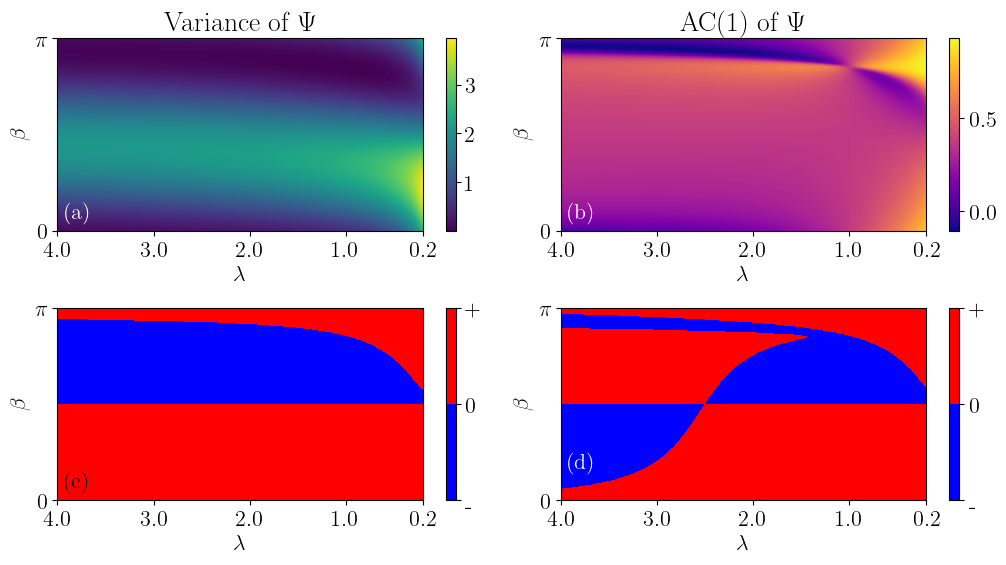

In [111]:
props = dict(edgecolor="none", facecolor='white', alpha=0)

# Generate the grid of points
x = np.linspace(0.2, 4, 500)
y = np.linspace(0, np.pi, 500)
X, Y = np.meshgrid(x, y)

# Calculate the function values
Z_f = theovar(X, Y)
Z_g = theoac1(X, Y)
Z_h = np.sign(-theodvar(X, Y))
Z_k = np.sign(-theodac1(X, Y))
Z_l = np.sign(-theodvar(X, Y))+np.sign(-theodac1(X, Y))

# Create the figure and the subplots
fig, axs = plt.subplots(2, 2, figsize=(2*6.2, 6))

# Plot heatmap for function f
c1 = axs[0, 0].imshow(Z_f, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis', aspect=4/(2*np.pi))
axs[0, 0].set_title('Variance of $\Psi$', fontsize=20)
axs[0, 0].set_yticks([0,np.pi])
axs[0, 0].set_xticks([4,3,2,1,0.2])
axs[0, 0].set_xlim([4, 0.2])
axs[0, 0].set_yticklabels(["0","$\pi$"])
axs[0, 0].set_xlabel("$\lambda$")
axs[0, 0].set_ylabel(r"$\beta$")
axs[0, 0].text(0.02, 0.15, "(a)", transform=axs[0, 0].transAxes, verticalalignment='top', bbox=props, color="white")
fig.colorbar(c1, ax=axs[0, 0])

# Plot heatmap for function g
c2 = axs[0, 1].imshow(Z_g, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='plasma', aspect=4/(2*np.pi))
axs[0, 1].set_title('AC(1) of $\Psi$', fontsize=20)
axs[0, 1].set_yticks([0,np.pi])
axs[0, 1].set_xticks([4,3,2,1,0.2])
axs[0, 1].set_xlim([4, 0.2])
axs[0, 1].set_yticklabels(["0","$\pi$"])
axs[0, 1].set_xlabel("$\lambda$")
axs[0, 1].set_ylabel(r"$\beta$")
axs[0, 1].text(0.02, 0.15, "(b)", transform=axs[0, 1].transAxes, verticalalignment='top', bbox=props, color="white")
fig.colorbar(c2, ax=axs[0, 1])

# Custom colormap for h and k
cmap_hk = ListedColormap(['blue', 'red'])

# Plot heatmap for function h with custom colormap
c3 = axs[1, 0].imshow(Z_h, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap=cmap_hk, vmin=-1, vmax=1, aspect=4/(2*np.pi))
axs[1, 0].set_yticks([0,np.pi])
axs[1, 0].set_xticks([4,3,2,1,0.2])
axs[1, 0].set_xlim([4, 0.2])
axs[1, 0].set_yticklabels(["0","$\pi$"])
axs[1, 0].set_xlabel("$\lambda$")
axs[1, 0].set_ylabel(r"$\beta$")
axs[1, 0].text(0.02, 0.15, "(c)", transform=axs[1, 0].transAxes, verticalalignment='top', bbox=props, color="black")
cbar3 = fig.colorbar(c3, ax=axs[1, 0], ticks=[-1, 0, 1])
cbar3.ax.set_yticklabels(['-', '0', '+'])

# Plot heatmap for function k with custom colormap
c4 = axs[1, 1].imshow(Z_k, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap=cmap_hk, vmin=-1, vmax=1, aspect=4/(2*np.pi))
axs[1, 1].set_yticks([0,np.pi])
axs[1, 1].set_xticks([4,3,2,1,0.2])
axs[1, 1].set_xlim([4, 0.2])
axs[1, 1].set_yticklabels(["0","$\pi$"])
axs[1, 1].set_xlabel("$\lambda$")
axs[1, 1].set_ylabel(r"$\beta$")
axs[1, 1].text(0.02, 0.25, "(d)", transform=axs[1, 1].transAxes, verticalalignment='top', bbox=props, color="white")
cbar4 = fig.colorbar(c4, ax=axs[1, 1], ticks=[-1, 0, 1])
cbar4.ax.set_yticklabels(['-', '0', '+'])

# Adjust layout
#plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.1)
plt.savefig("Plots/Planar" + time.strftime("%Y%m%d-%H%M%S") + '.pdf', transparent=True, bbox_inches="tight", dpi=300)
plt.show()

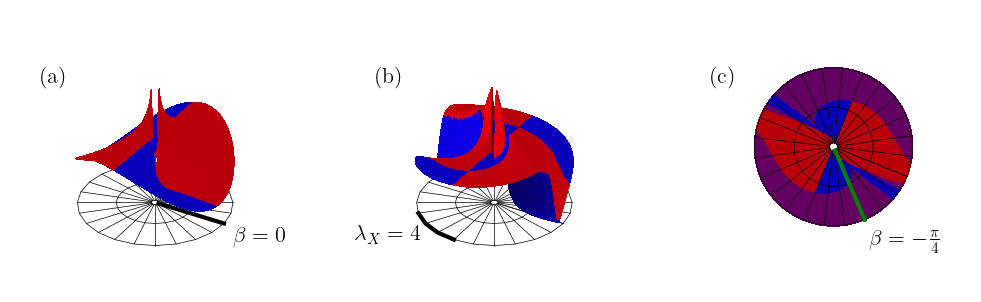

In [ ]:
fig = plt.figure(figsize = (2*6.2,2*4))
props = dict(edgecolor="none", facecolor='white', alpha=0)
# Define your custom colormap colors
colors = [(0.0, 'blue'), (0.5, 'purple'), (1.0, 'red')]

# Create the colormap using LinearSegmentedColormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

ax = fig.add_subplot(1, 3, 1, projection='3d')

# Create the mesh in polar coordinates and compute corresponding Z.
r = np.linspace(0.2, 4, 500)
p = np.linspace(0, 2*np.pi, 500)
R, P = np.meshgrid(r, p)
Z = theovar(R, P) + 0.01
C1 = -1*np.sign(theodvar(R, P))*0.45 + 0.5

# Express the mesh in the cartesian system.
X, Y = R*np.cos(P), R*np.sin(P)

# Plot the surface.
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors = custom_cmap(C1), linewidth=0, antialiased=False, alpha=1)
ax.set_axis_off()

# Add polar coordinate axes
theta = np.linspace(0, 2 * np.pi, 25, endpoint=True)
radius = np.array([0.2, 2, 4])

for r in radius:
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    ax.plot(x, y, 0, color='black', linewidth=0.5)

for t in theta:
    x = radius * np.cos(t)
    y = radius * np.sin(t)
    ax.plot(x, y, 0, color='black', linewidth=0.5)

x = radius * np.cos(0)
y = radius * np.sin(0)
ax.plot(x, y, 0, color='black', linewidth=3, zorder=2)
ax.text(4.5 * np.cos(0), 4.5 * np.sin(0), 0, r"$\beta=0$", verticalalignment='top', bbox=props)





ax = fig.add_subplot(1, 3, 2, projection='3d')

# Create the mesh in polar coordinates and compute corresponding Z.
Z = theoac1(R, P) + 0.15
C2 = -1*np.sign(theodac1(R, P))*0.45 + 0.5

# Express the mesh in the cartesian system.
X, Y = R*np.cos(P), R*np.sin(P)

# Plot the surface.
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors = custom_cmap(C2), linewidth=0, antialiased=False, alpha=1)
ax.set_axis_off()

for r in radius:
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    ax.plot(x, y, 0, color='black', linewidth=0.5)

for t in theta:
    x = radius * np.cos(t)
    y = radius * np.sin(t)
    ax.plot(x, y, 0, color='black', linewidth=0.5)

x = 4 * np.cos(theta[-10:-6])
y = 4 * np.sin(theta[-10:-6])
ax.plot(x, y, 0, color='black', linewidth=3, zorder=2)
ax.text(5 * np.cos(theta[-8]), 5 * np.sin(theta[-8]), 0, r"$\lambda_X=4$", horizontalalignment='right', bbox=props)





ax = fig.add_subplot(1, 3, 3, projection='3d')

# Create the mesh in polar coordinates and compute corresponding Z.
Z = np.full_like(Z, 0)
C = (C1 + C2)/2

# Express the mesh in the cartesian system.
X, Y = R*np.cos(P), R*np.sin(P)

# Plot the surface.
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors = custom_cmap(C), linewidth=0, antialiased=False, alpha=1, zorder=1)
ax.set_axis_off()
ax.view_init(elev=90, azim=290)

for r in radius:
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    ax.plot(x, y, 0, color='black', linewidth=0.5, zorder=10)

for t in theta:
    x = radius * np.cos(t)
    y = radius * np.sin(t)
    ax.plot(x, y, 0, color='black', linewidth=0.5, zorder=10)

x = radius * np.cos(-np.pi/4)
y = radius * np.sin(-np.pi/4)
ax.plot(x, y, 0, color='green', linewidth=3, zorder=10)
ax.text(4.5 * np.cos(-np.pi/4), 4.5 * np.sin(-np.pi/4), 0, r"$\beta=-\frac{\pi}{4}$", verticalalignment='top', bbox=props)



fig.text(0.15, 0.6, "(a)", verticalalignment='top', bbox=props)
fig.text(0.42, 0.6, "(b)", verticalalignment='top', bbox=props)
fig.text(0.69, 0.6, "(c)", verticalalignment='top', bbox=props)
#plt.savefig("Plots/Radial" + time.strftime("%Y%m%d-%H%M%S") + '.png', transparent=True, bbox_inches="tight", dpi=300)
plt.show()